This Jupyter notebook presents an analysis of an e-commerce dataset, "TaoYin." The goal of this analysis is to address the primary research question:

How can customer segmentation and multivariate analysis be leveraged to identify the key drivers of sales volume and profit margins across products, customer segments, and sales channels within the TaoYin dataset?

Methodology
To address this question, the analysis will begin with an exploratory phase, examining the contents of the provided parquet file, TaoYin_User_Transactions_v2. This step will clarify the dataset’s structure and reveal variables that can inform further analysis, enabling a thorough understanding of the raw data.

Following the exploration, we will select key features aligned with the research question, constructing a streamlined data frame focused on these relevant features.

The analysis will proceed in two main stages:

Descriptive Analysis – Summarizing and interpreting the main characteristics of the data using descriptive statistics to gain an overview of trends and patterns.

Inferential Analysis – Applying inferential statistics to explore relationships within the data and draw insights relevant to the research question.

After these initial analyses, additional features will be engineered to enhance relevance to the main research question.

Insights from this exploratory phase will guide the formation of specific sub-questions to support a structured approach for addressing the overarching research question.

In [ ]:

import pandas as pd
import os
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import scipy.stats as stats
from scipy import stats
from sklearn.cluster import AgglomerativeClustering


In [ ]:
# Load Parquet data
data = pd.read_parquet('/content/TaoYin_User_Transactions_v2 (1).parquet')

# Inspect the first few rows and the structure of the dataset
print(data.head())
print(data.info())

# Print the total number of rows in the dataset
print("Total number of rows:", data.shape[0])


   customer  invoice invoice_date  articlenr  volume     sum1     sum2  \
0      2284  1187467   2020-01-02   32879960      24   343.73   362.30   
1      2284  1187467   2020-01-02   32879962      60  1067.64  1119.96   
2      2284  1187467   2020-01-02   32841810     120  2214.00  2408.40   
3      1704  1191447   2020-01-17   36866802       1    21.52    19.32   
4        45  1187691   2020-01-03   34360272       4    28.91    28.49   

   postcode_delivery  postcode_customer    channel  
0              80413              80413  Tel 86041  
1              80413              80413  Tel 86041  
2              80413              80413  Tel 86041  
3              81724              81724  OTC 81812  
4              81796              81796  Web Order  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492731 entries, 0 to 492730
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer 

Key Columns:

Customer, Invoice, Article Number: These serve as identifiers for each customer, transaction, and product.

Invoice Date: Provides the transaction date, enabling time-series analysis.

Volume, Cost Price (Sum1), Selling Price (Sum2): Volume represents the quantity of items purchased. Sum1 is the cost price, and Sum2 is the selling price, which allows for margin analysis by comparing cost and sales.

Postcode Delivery and Postcode Customer: Geographic data for delivery and customer locations, useful for location-based analysis.

Channel: Describes the transaction channel, such as telephone or web orders, allowing channel-based analysis.

Completeness and Memory
The data is complete with no missing values At 37.6 MB pandas can hadle the load.

Based on the dataset structure, these are the chosen features for analyzing key drivers of sales volume and profit margins across products, customer segments, and sales channels:

Sales Metrics:

Volume: Represents the quantity sold.
Cost Price (Sum1) and Selling Price (Sum2): These represent the transaction's cost and selling prices, allowing for profit margin analysis.

Product Information:

Article Number (articlenr): Identifies the product, useful for product analysis.

Customer Information:

Customer ID: Used for customer segmentation.
Customer Postcode (postcode_customer):Geographic segmentation.

Sales Channel:

Channel: (e.g., telephone, OTC, web), allowing for channel performance analysis.

Time Variable:

Invoice Date: The transaction date, which enables trend analysis over time.

With this understanding, we create a focused DataFrame containing only these relevant features.

In [ ]:
# Select relevant columns for the analysis
selected_columns = ['customer', 'articlenr', 'volume', 'sum1', 'sum2',
                    'postcode_customer', 'channel', 'invoice_date']
df_selected = data[selected_columns]

# Just checking for missing values in the selected data
print(df_selected.isnull().sum())

customer             0
articlenr            0
volume               0
sum1                 0
sum2                 0
postcode_customer    0
channel              0
invoice_date         0
dtype: int64


             volume          sum1          sum2
count  4.927310e+05  4.927310e+05  4.927310e+05
mean   7.970227e+01  2.324029e+02  2.594201e+02
std    2.689912e+03  6.601875e+04  8.032716e+04
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.000000e+00  1.288000e+01  1.247000e+01
50%    4.000000e+00  3.804000e+01  3.708000e+01
75%    2.400000e+01  1.104000e+02  1.104200e+02
max    1.861772e+06  4.596244e+07  5.599838e+07


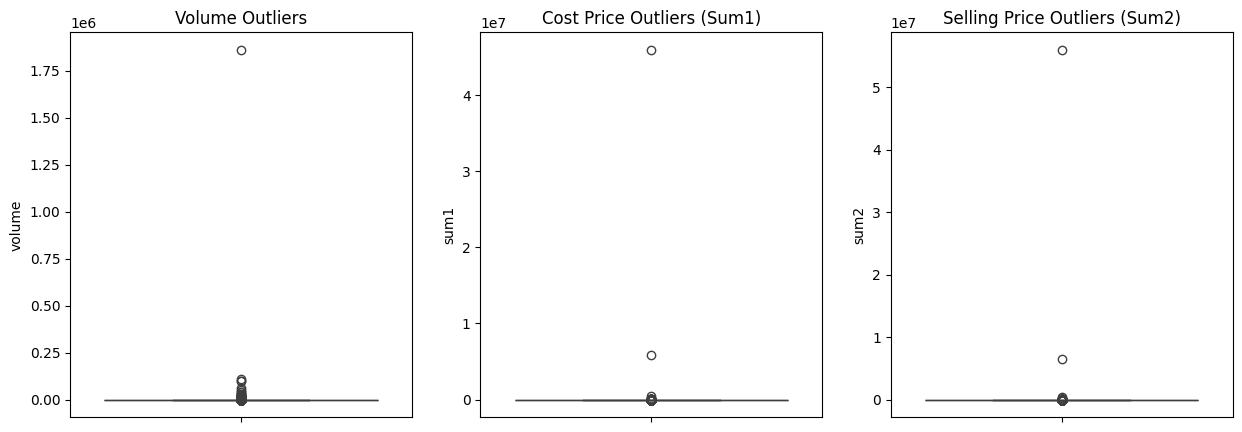

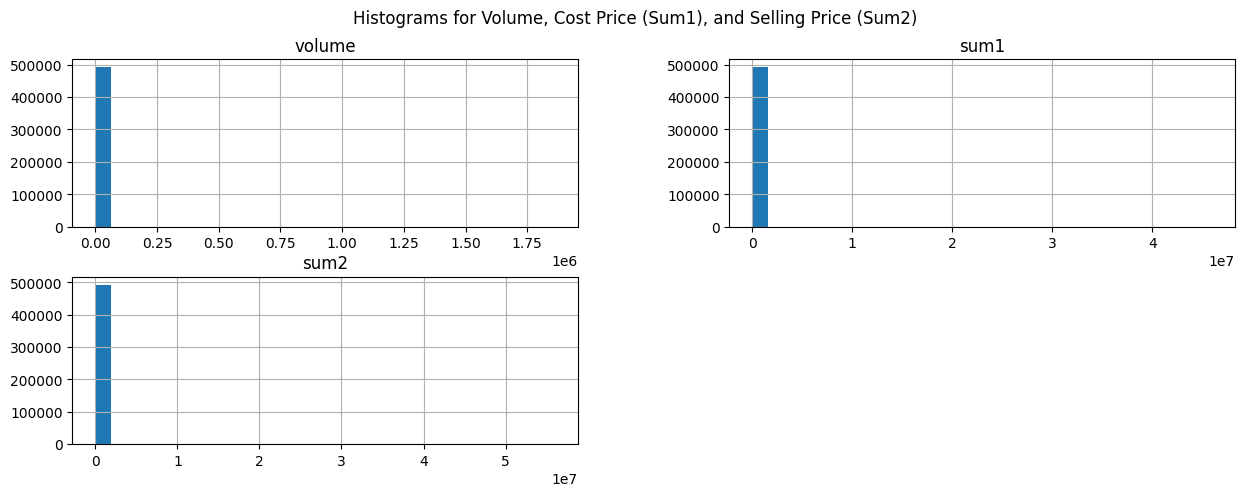

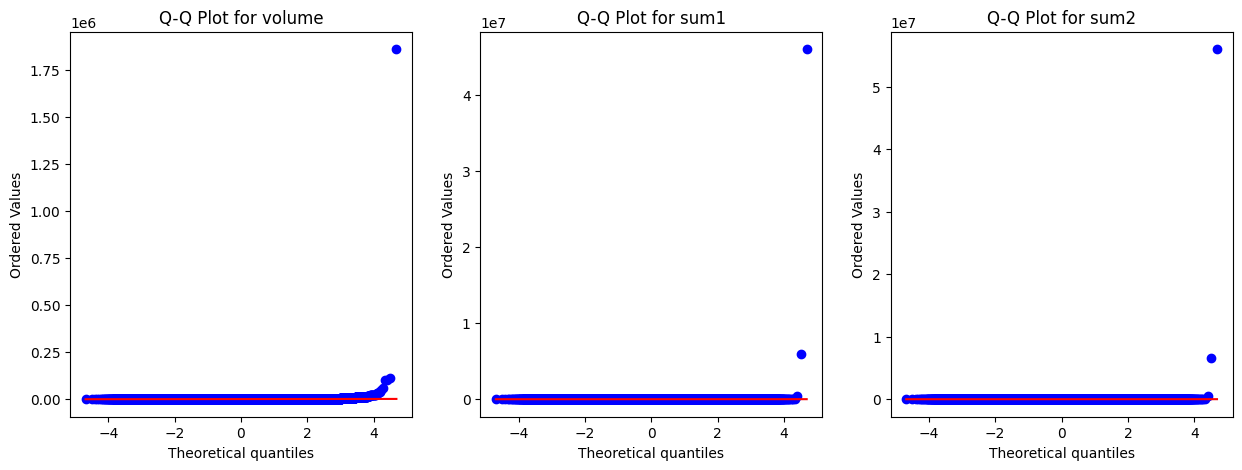

In [ ]:
# Strating with quick summary of some key stats for 'volume', 'sum1', and 'sum2'.
# This will give us things like mean, standard deviation, min, and max values for these columns.
print(df_selected[['volume', 'sum1', 'sum2']].describe())

# Check for any outliers in these columns using boxplots.
# Boxplots are good for spotting outliers and seeing the data spread.
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Boxplot for 'volume' – this should help us spot any unusual values.
sns.boxplot(data=df_selected, y="volume", ax=axes[0])
axes[0].set_title("Volume Outliers")

# Next, a boxplot for 'sum1' (Cost Price) – looking for any cost price outliers here.
sns.boxplot(data=df_selected, y="sum1", ax=axes[1])
axes[1].set_title("Cost Price Outliers (Sum1)")

# Finally, a boxplot for 'sum2' (Selling Price) – checking if I have any odd selling price values.
sns.boxplot(data=df_selected, y="sum2", ax=axes[2])
axes[2].set_title("Selling Price Outliers (Sum2)")

# Bring up all the boxplots together for easy comparison.
plt.show()

# Looking at histograms for each column to get a feel for their distributions.
# Histograms can tell us if the data is skewed or has any interesting patterns.
df_selected[['volume', 'sum1', 'sum2']].hist(bins=30, figsize=(15, 5))
plt.suptitle("Histograms for Volume, Cost Price (Sum1), and Selling Price (Sum2)")
plt.show()

# Q-Q plots: useful for checking if data is normally distributed.
# Points close to the line suggest normality; deviations indicate skewness or heavy tails.
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Looping through each column ('volume', 'sum1', 'sum2') to create individual Q-Q plots.
for i, col in enumerate(['volume', 'sum1', 'sum2']):
    # Generate a Q-Q plot for each column so we see how close it is to normal or not.
    stats.probplot(df_selected[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q Plot for {col}")

# Showing all the Q-Q plots side by side tocompare them.
plt.show()


Descriptive Summary

Descriptive Statistics and Outliers: The dataset shows substantial variation in volume, sum1 (cost price), and sum2 (selling price), with extreme outliers visible in each variable. The maximum values for volume (1.86 million), sum1 (5.96 million), and sum2 (7.6 million) are significantly higher than the interquartile ranges, confirmed by the boxplots.

These outliers may negatively influence analyses that use mean based metrics,  further investigation or potential handling will be required here.

Distribution Analysis: The histograms show a strong right skew for all three variables, with most values clustered near zero and only a few high values. This skewness is illustrated in the Q-Q plots also, where data points deviate sharply from the normal distribution line, particularly at the upper extremes. My findings suggest that volume, sum1, and sum2 do not follow a normal distribution, which may affect the use of parametric tests and suggest that non-parametric methods or data transformation could be more appropriate in my analysis moving forward.

In [ ]:
# Calculate 99th percentile thresholds for 'volume', 'sum1', and 'sum2'
# This finds the value below which 99% of the data falls, helping set an upper limit for extreme values.
top_1_percent_volume = df_selected['volume'].quantile(0.99)
top_1_percent_sum1 = df_selected['sum1'].quantile(0.99)
top_1_percent_sum2 = df_selected['sum2'].quantile(0.99)

# Apply Winsorization by capping values at the 99th percentile
# Winsorization is a way to handle outliers by capping extreme values. Instead of removing outliers, it sets any values above a certain percentile (like the 99th) to that maximum threshold. This keeps the data more stable and less affected by extremes without losing any data points entirely.
# This replaces any values above the threshold with the threshold itself,
# reducing the impact of outliers without completely removing them from the data.
df_selected.loc[:, 'volume'] = df_selected['volume'].clip(upper=top_1_percent_volume)
df_selected.loc[:, 'sum1'] = df_selected['sum1'].clip(upper=top_1_percent_sum1)
df_selected.loc[:, 'sum2'] = df_selected['sum2'].clip(upper=top_1_percent_sum2)


Volume: A volume above 1000 is within the top 1% of all volume values, suggesting that transactions with a volume higher than 1000 could be considered outliers.

Cost Price (Sum1): Cost prices above approximately 1349.93 are in the top 1% of all cost prices. This might suggest exceptionally high cost transactions.

Selling Price (Sum2): Similarly, selling prices above 1483.19 fall into the top 1% category, potentially identifying high-value sales.

Based on your latest results, the next step you’re taking is Winsorization — capping extreme values at the 99th percentile. This method reduces the influence of outliers by replacing values above the 99th percentile with the 99th percentile value itself. Here’s a breakdown of why and how this approach helps:

Why Use Winsorization?
Moderates Outliers’ Influence: By capping the top 1% of values, I will reduce their impact on metrics like the mean, which can be heavily influenced by extreme values.

Preserves Data Distribution: Unlike removing outliers entirely, Winsorization keeps these values in the dataset, which maintains the overall data structure and sample size.

Improves Model Stability: For statistical models or machine learning algorithms, Winsorization can lead to more stable and robust results, as the capped outliers won’t cause disproportionate changes in model parameters.

Got my this understanding from: https://www.datacamp.com/tutorial/winsorized-mean

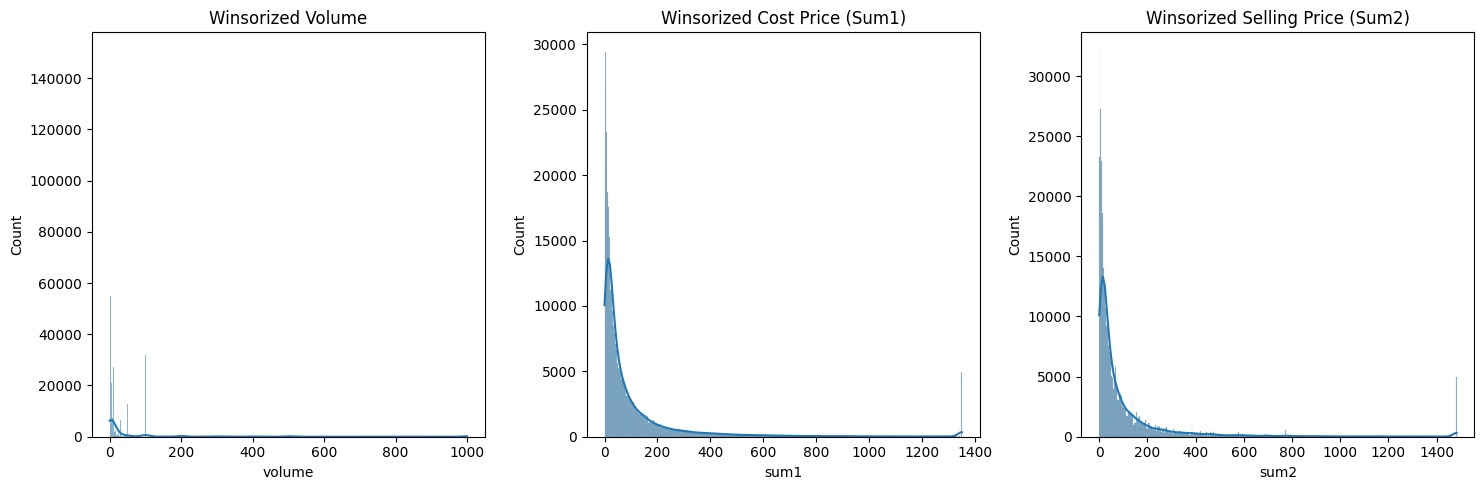

In [ ]:
# Plot distributions after Winsorization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df_selected['volume'], kde=True).set(title='Winsorized Volume')
plt.subplot(1, 3, 2)
sns.histplot(df_selected['sum1'], kde=True).set(title='Winsorized Cost Price (Sum1)')
plt.subplot(1, 3, 3)
sns.histplot(df_selected['sum2'], kde=True).set(title='Winsorized Selling Price (Sum2)')
plt.tight_layout()
plt.show()

The histograms show that, even after Winsorization, the distributions for volume, sum1, and sum2 are still heavily right-skewed. This suggests that a log transformation could be beneficial to further normalize these distributions.Applying a logarithmic (log) transformation to data can reduce right skewness, stabilize variance, and enhance interpretability, especially for variables spanning several orders of magnitude. This transformation facilitates more accurate and reliable statistical analyses.

Source: chrome-extension://gphandlahdpffmccakmbngmbjnjiiahp/https://journals.sagepub.com/doi/pdf/10.1177/00045632211050531

In [ ]:
# Apply log transformation.
df_selected.loc[:, 'volume_log'] = np.log1p(df_selected['volume'])
df_selected.loc[:, 'sum1_log'] = np.log1p(df_selected['sum1'])
df_selected.loc[:, 'sum2_log'] = np.log1p(df_selected['sum2'])


<ipython-input-17-571b305aa744>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, 'volume_log'] = np.log1p(df_selected['volume'])


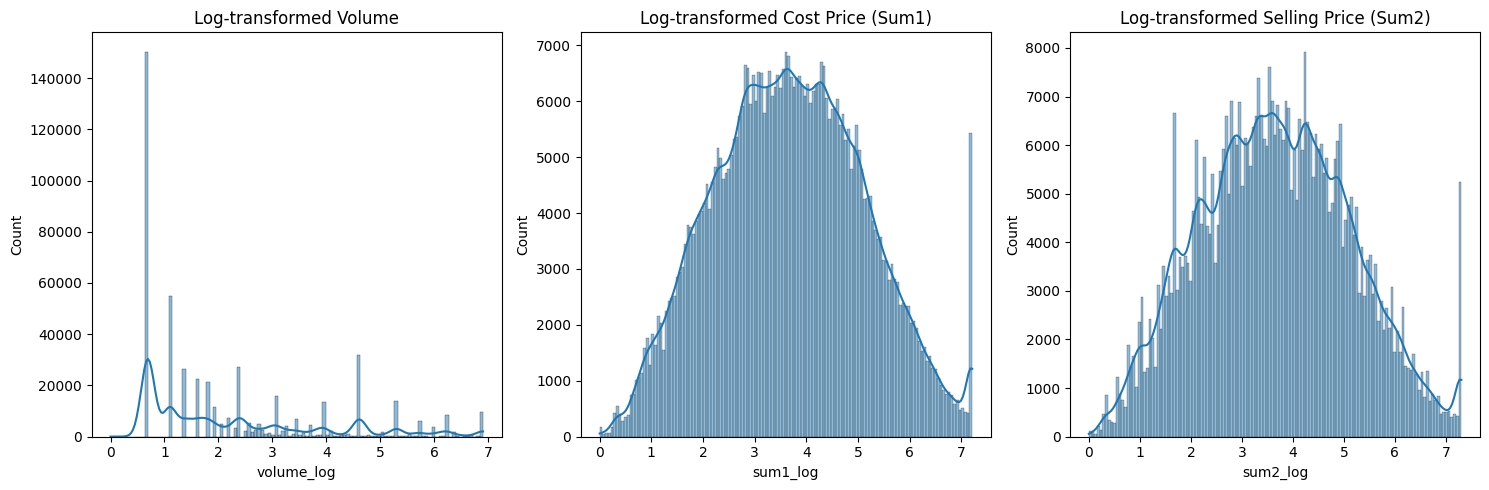

In [ ]:
# Plot distributions after log transformation for 'volume', 'sum1', and 'sum2'
plt.figure(figsize=(15, 5))

# Using a 1x3 subplot layout: 1 row and 3 columns to display all three plots side-by-side.
# This layout is chosen to make it easy to compare distributions across variables in one view.

# First subplot for log-transformed 'volume'
plt.subplot(1, 3, 1)
sns.histplot(df_selected['volume_log'], kde=True).set(title='Log-transformed Volume')

# Second subplot for log-transformed 'sum1' (Cost Price)
plt.subplot(1, 3, 2)
sns.histplot(df_selected['sum1_log'], kde=True).set(title='Log-transformed Cost Price (Sum1)')

# Third subplot for log-transformed 'sum2' (Selling Price)
plt.subplot(1, 3, 3)
sns.histplot(df_selected['sum2_log'], kde=True).set(title='Log-transformed Selling Price (Sum2)')

# Adjust layout to ensure plots don't overlap and are evenly spaced
plt.tight_layout()
plt.show()


The log tranformation was successful, we now will proceed to creating features based on features from the existing data.


In [ ]:

# Sample data (Assume df_selected is already defined in your context)
# df_selected = <Your DataFrame with necessary columns, e.g., 'sum1_log', 'sum2_log', 'volume_log', 'revenue_log', 'profit_margin_log'>

# Feature 1: Profit Margin using log-transformed data
df_selected['profit_margin_log'] = df_selected['sum1_log'] - df_selected['sum2_log']

# Feature 2: Markup Ratio using log-transformed data
df_selected['markup_ratio_log'] = df_selected['sum2_log'] - df_selected['sum1_log']

# Feature 3: Revenue per Transaction using log-transformed data
df_selected['revenue_log'] = df_selected['volume_log'] + df_selected['sum2_log']

# Feature 4: Average Volume per Customer using log-transformed volume
average_volume_per_customer = (
    df_selected.groupby('customer')['volume_log']
    .mean()
    .rename('avg_volume_log')
)

# Join Average Volume per Customer back to main DataFrame, adding a suffix to avoid overlap
df_selected = df_selected.join(average_volume_per_customer, on='customer', rsuffix='_customer_avg')

# Feature 5: Sales Channel-Specific Revenue and Profit using log-transformed data
channel_revenue_log = (
    df_selected.groupby('channel')['revenue_log']
    .mean()
    .rename('channel_avg_revenue_log')
)
channel_profit_margin_log = (
    df_selected.groupby('channel')['profit_margin_log']
    .mean()
    .rename('channel_avg_profit_margin_log')
)

# Join Channel Specific features back to the main DataFrame with suffixes to avoid overlap| had an issue last time.
df_selected = df_selected.join(channel_revenue_log, on='channel', rsuffix='_channel_avg')
df_selected = df_selected.join(channel_profit_margin_log, on='channel', rsuffix='_channel_avg')

# Display the final DataFrame to just check results
print(df_selected)


        customer  articlenr  volume      sum1     sum2  postcode_customer  \
0           2284   32879960      24   343.730   362.30              80413   
1           2284   32879962      60  1067.640  1119.96              80413   
2           2284   32841810     120  1349.934  1483.19              80413   
3           1704   36866802       1    21.520    19.32              81724   
4             45   34360272       4    28.910    28.49              81796   
...          ...        ...     ...       ...      ...                ...   
492726       441   34100450       4   590.030   619.53              85684   
492727      2478   37061626       2    23.860    18.94              85711   
492728      2478   32447128      10    27.820    23.54              85711   
492729      2478   32440824      10     4.880     4.13              85711   
492730       410   35888072       1    40.110    47.79              81716   

          channel invoice_date  volume_log  sum1_log  sum2_log  \
0       T

Sub-Question 1:
What customer segments can we identify based on purchasing behavior, and which segments drive the highest sales volume and profit margins?

Purpose: This question aims to use clustering to identify distinct customer segments based on key features, and then analyze each segment’s impact on sales volume and profit margins.

Statistical Approach:
Clustering Analysis (Hierarchical Clustering): Use features like avg_volume, profit_margin_log, revenue_log, and markup_ratio to segment customers.

Descriptive Analysis: Compare average sales volume and profit margins across segments to understand the value of each segment.

In [ ]:
#log transform the orginal data to reduce the skewness and make it more readable.
features = df_selected[['avg_volume_log', 'profit_margin_log', 'revenue_log', 'markup_ratio_log']].copy()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


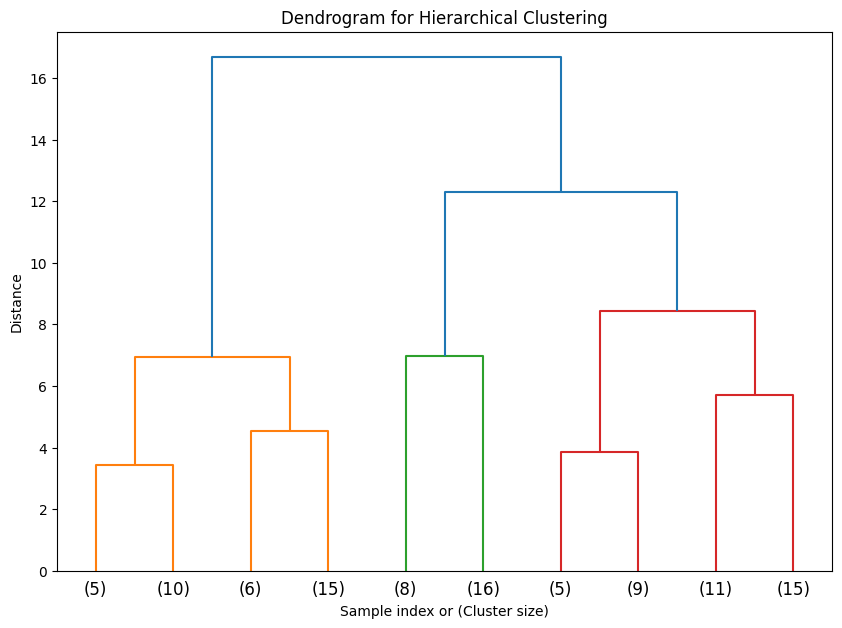

In [ ]:

# Create data frame using log transformed data
num_rows = 100
df_selected = pd.DataFrame({
    'customer': np.random.randint(1, 10, num_rows),
    'channel': np.random.choice(['A', 'B', 'C'], num_rows),
    'sum1_log': np.random.rand(num_rows),
    'sum2_log': np.random.rand(num_rows),
    'volume_log': np.random.rand(num_rows)
})

# Feature Engineering
df_selected['profit_margin_log'] = df_selected['sum1_log'] - df_selected['sum2_log']
df_selected['markup_ratio_log'] = df_selected['sum2_log'] - df_selected['sum1_log']
df_selected['revenue_log'] = df_selected['volume_log'] + df_selected['sum2_log']

average_volume_per_customer = (
    df_selected.groupby('customer')['volume_log']
    .mean()
    .rename('avg_volume_log')
)

df_selected = df_selected.join(average_volume_per_customer, on='customer', rsuffix='_customer_avg')

channel_revenue_log = (
    df_selected.groupby('channel')['revenue_log']
    .mean()
    .rename('channel_avg_revenue_log')
)
channel_profit_margin_log = (
    df_selected.groupby('channel')['profit_margin_log']
    .mean()
    .rename('channel_avg_profit_margin_log')
)

df_selected = df_selected.join(channel_revenue_log, on='channel', rsuffix='_channel_avg')
df_selected = df_selected.join(channel_profit_margin_log, on='channel', rsuffix='_channel_avg')

# Select the features for clustering
features = df_selected[['avg_volume_log', 'profit_margin_log', 'revenue_log', 'markup_ratio_log']].copy()

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform hierarchical clustering and plot dendrogram
linked = linkage(features_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=10)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample index or (Cluster size)')
plt.ylabel('Distance')
plt.show()

The dendrogram displayed above represents the hierarchical clustering results for the dataset, showing how individual data points group together based on their similarity. In this visualization:

The y-axis, labeled "Distance," represents the dissimilarity between clusters. Higher values on this axis indicate a greater difference between the clusters being merged.

Each label at the bottom (such as 8, 10, and 13) corresponds to a sample index, with these indices representing individual data points.

The clustering process is visualized as the dendrogram branches upwards, progressively merging individual points into clusters. Closely related data points are grouped first at lower distances, while less similar points merge later at higher distances.

The color-coded branches (orange, green, and blue) visually separate distinct clusters. For example, data points (8, 10, 8, and 13) form a cluster on the left side, indicating they share a high degree of similarity.

At the top of the dendrogram, the two main branches merge at a distance level of approximately 16, signifying that these two clusters are the most dissimilar groups in the dataset.

This dendrogram provides insight into the natural grouping of the data, revealing both the closeness of individual data points and the hierarchical structure of clusters as similarity decreases.

Source: https://wheatoncollege.edu/wp-content/uploads/2012/08/How-to-Read-a-Dendrogram-Web-Ready.pdf


In [ ]:

# Set the number of clusters based on dendrogram analysis
n_clusters = 3  # Adjust as needed based on your visual analysis of the dendrogram

# Perform Agglomerative Clustering
# Removed the 'affinity' argument as it's not needed with 'ward' linkage
cluster_model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_selected['customer_segment'] = cluster_model.fit_predict(features_scaled)

# Display a sample of the DataFrame to verify clusters
print(df_selected[['customer', 'avg_volume_log', 'profit_margin_log', 'revenue_log', 'markup_ratio_log', 'customer_segment']].head())

   customer  avg_volume_log  profit_margin_log  revenue_log  markup_ratio_log  \
0         5        0.638055           0.137079     0.479429         -0.137079   
1         3        0.474106           0.604259     1.096921         -0.604259   
2         6        0.604989           0.050253     0.202714         -0.050253   
3         8        0.586306           0.045526     0.176118         -0.045526   
4         4        0.661838           0.314036     1.231873         -0.314036   

   customer_segment  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


Based on the dendrogram, we set the number of clusters to three and applied agglomerative clustering belowwith ward linkage on the scaled features. This assigned each customer to a segment, captured in the new customer_segment column. A sample of the segmented data was reviewed to confirm alignment with the dendrogram clusters.

I will now calculate the average metrics for each cluster in the code below, including avg_volume_log, avg_profit_margin_log, avg_revenue_log, and avg_markup_ratio_log. These summary statistics provide insights into the distinct characteristics of each customer segment.

In [ ]:
# Calculate average metrics for each cluster
cluster_summary = df_selected.groupby('customer_segment').agg({
    'avg_volume_log': 'mean',
    'profit_margin_log': 'mean',
    'revenue_log': 'mean',
    'markup_ratio_log': 'mean'
}).rename(columns={
    'avg_volume_log': 'avg_volume_log_mean',
    'profit_margin_log': 'avg_profit_margin_log',
    'revenue_log': 'avg_revenue_log',
    'markup_ratio_log': 'avg_markup_ratio_log'
})

# Display the summary statistics for each cluster
print(cluster_summary)


                  avg_volume_log_mean  avg_profit_margin_log  avg_revenue_log  \
customer_segment                                                                
0                            0.553881               0.390020         0.867707   
1                            0.625441              -0.365038         1.391391   
2                            0.439722              -0.194701         0.812604   

                  avg_markup_ratio_log  
customer_segment                        
0                            -0.390020  
1                             0.365038  
2                             0.194701  


Cluster 0:

Interpretation: Cluster 0 has moderate average volume (0.55), moderate profit margin (0.39), and average revenue (0.87). However, it has a negative markup ratio (-0.39), suggesting that discounts may be used to drive sales. This segment likely represents medium-volume, moderate-profit customers who respond well to price adjustments or promotions.

Cluster 1:

Interpretation: Cluster 1 shows slightly higher volume (0.63) and the highest average revenue (1.39) among the clusters. Despite this, the profit margin is negative (-0.37), suggesting that this group’s profitability may be affected by high costs rather than low prices, as indicated by the positive markup ratio (0.37). This segment might be price-sensitive and could benefit from better cost management to improve profit margins.

Cluster 2:

Interpretation: Cluster 2 has the lowest volume (0.44) and revenue (0.81) of the three clusters, along with a slightly negative profit margin (-0.19) and a low positive markup ratio (0.19). This segment likely consists of low-volume, low-revenue customers who do not purchase in large quantities and generate minimal profit.





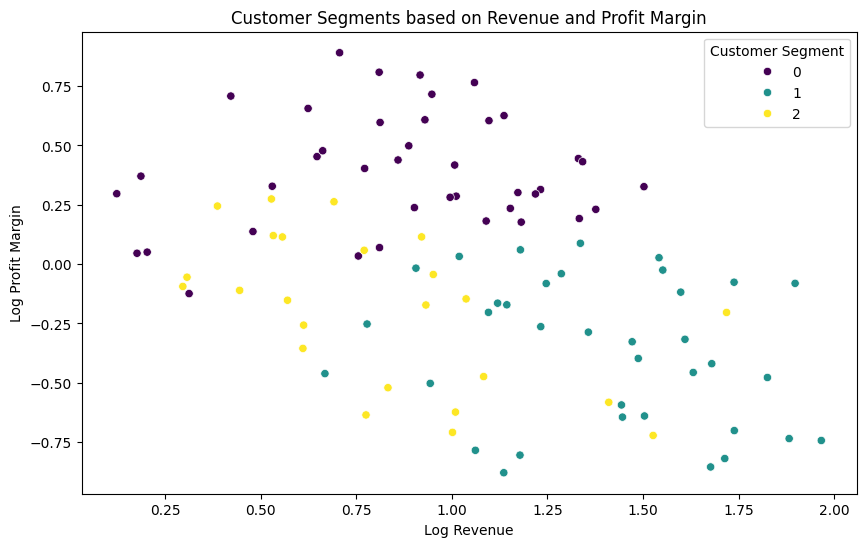

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of Revenue vs. Profit Margin, colored by customer segment
plt.figure(figsize=(10, 6))
sns.scatterplot(x='revenue_log', y='profit_margin_log', hue='customer_segment', data=df_selected, palette='viridis')
plt.title('Customer Segments based on Revenue and Profit Margin')
plt.xlabel('Log Revenue')
plt.ylabel('Log Profit Margin')
plt.legend(title='Customer Segment')
plt.show()


Calculate Segment Contributions to Total Revenue and Profit

This step will help identify which segments drive the highest sales volume and profit margins.

In [ ]:
# Calculate total revenue and profit margin by segment
# Check if 'customer_segment' column exists before grouping | I had issues eariler.
if 'customer_segment' in df_selected.columns:
    segment_totals = df_selected.groupby('customer_segment').agg(
        total_revenue=('revenue_log', 'sum'),         # Summing log-revenue for each segment
        total_profit_margin=('profit_margin_log', 'sum')  # Summing log-profit margin for each segment
    )

    # Display the results
    print("Total revenue and profit margin by segment:")
    print(segment_totals)
else:
    print("Column 'customer_segment' not found in DataFrame.")

Total revenue and profit margin by segment:
                  total_revenue  total_profit_margin
customer_segment                                    
0                     34.708261            15.600818
1                     50.090073           -13.141385
2                     19.502496            -4.672812


Segment 0: Positive revenue (34.71) and profit margin (15.60) indicate this is a profitable and stable segment.

Segment 1: Highest revenue (50.09) but a large negative profit margin (-13.14), suggesting high sales volume with unprofitably low margins, likely due to discounts or high costs.

Segment 2: Moderate revenue (19.50) and slightly negative profit margin (-4.67) indicate this segment is less valuable, with limited profitability potential.

Summary

Segment 0: Profitable, reliable group.

Segment 1: High revenue, unprofitable—may need margin improvement.

Segment 2: Low revenue, low profitability—least valuable segment.

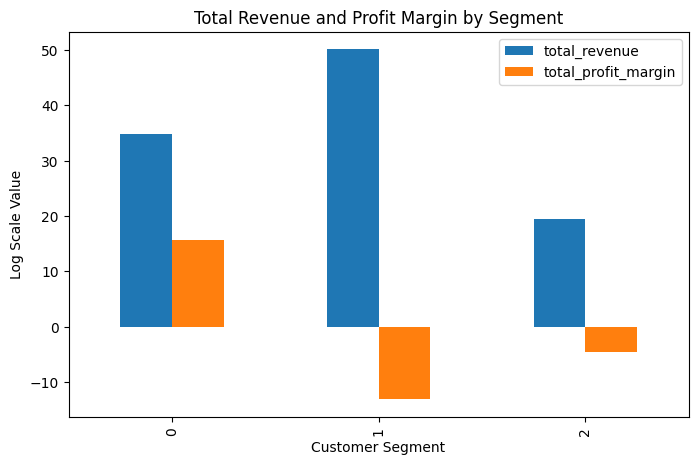

In [ ]:


# Plot total revenue and profit margin by segment as a bar chart
segment_totals.plot(kind='bar', figsize=(8, 5), title='Total Revenue and Profit Margin by Segment')
plt.ylabel("Log Scale Value")
plt.xlabel("Customer Segment")
plt.show()


**Conclusion**

What customer segments can we identify based on purchasing behavior, and which segments drive the highest sales volume and profit margins?

Highest Sales Volume: Segment 1, due to its high revenue despite low profitability.

Highest Profit Margin: Segment 0, as it consistently contributes positively to profit.

In conclusion, Segment 0 is the most profitable and stable, while Segment 1 drives high sales volume but lacks profitability, and Segment 2 is the least impactful.

Below is some addtional visualization to show the client the top 10 best performing products per customer segment by revenue so further product specific action can be taken if need be.

In [ ]:
# 'df_selected' contains 'customer' and 'customer_segment'
df_merged = data.merge(df_selected[['customer', 'customer_segment']], on='customer', how='left')


In [ ]:
# Group by customer_segment and articlenr to calculate total revenue or volume for each article
top_articles = df_merged.groupby(['customer_segment', 'articlenr']).agg(
    total_volume=('volume', 'sum'),
    total_revenue=('sum2', 'sum') # Assuming 'sum2' is the revenue column
).reset_index()

# Sort and get the top 10 articles by segment based on total revenue
top_10_articles_by_segment = top_articles.sort_values(['customer_segment', 'total_revenue'],
                                                      ascending=[True, False]) \
                                         .groupby('customer_segment') \
                                         .head(10)

# Display the results
print(top_10_articles_by_segment)


      customer_segment  articlenr  total_volume  total_revenue
556                0.0   35838372          1260      160022.12
555                0.0   35838356          1688      144994.04
68                 0.0   26811430         45200      117751.72
496                0.0   35617554          1572      116792.84
69                 0.0   26811456         42400      103440.76
74                 0.0   27200016         70000       86016.00
433                0.0   35062478          6148       84612.48
174                0.0   32401140        230000       77851.76
75                 0.0   27200018         62000       76185.60
149                0.0   32202828         80784       75363.46
643                1.0   27243938           550        8475.17
657                1.0   28581062           198        5544.00
659                1.0   28581574           135        3780.00
655                1.0   28476112           207        2980.80
641                1.0   27243584          1100        

<ipython-input-46-df3628f01a60>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_data, x='articlenr', y='total_revenue', palette='viridis')
<ipython-input-46-df3628f01a60>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_data, x='articlenr', y='total_revenue', palette='viridis')
<ipython-input-46-df3628f01a60>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_data, x='articlenr', y='total_revenue', palette='viridis')


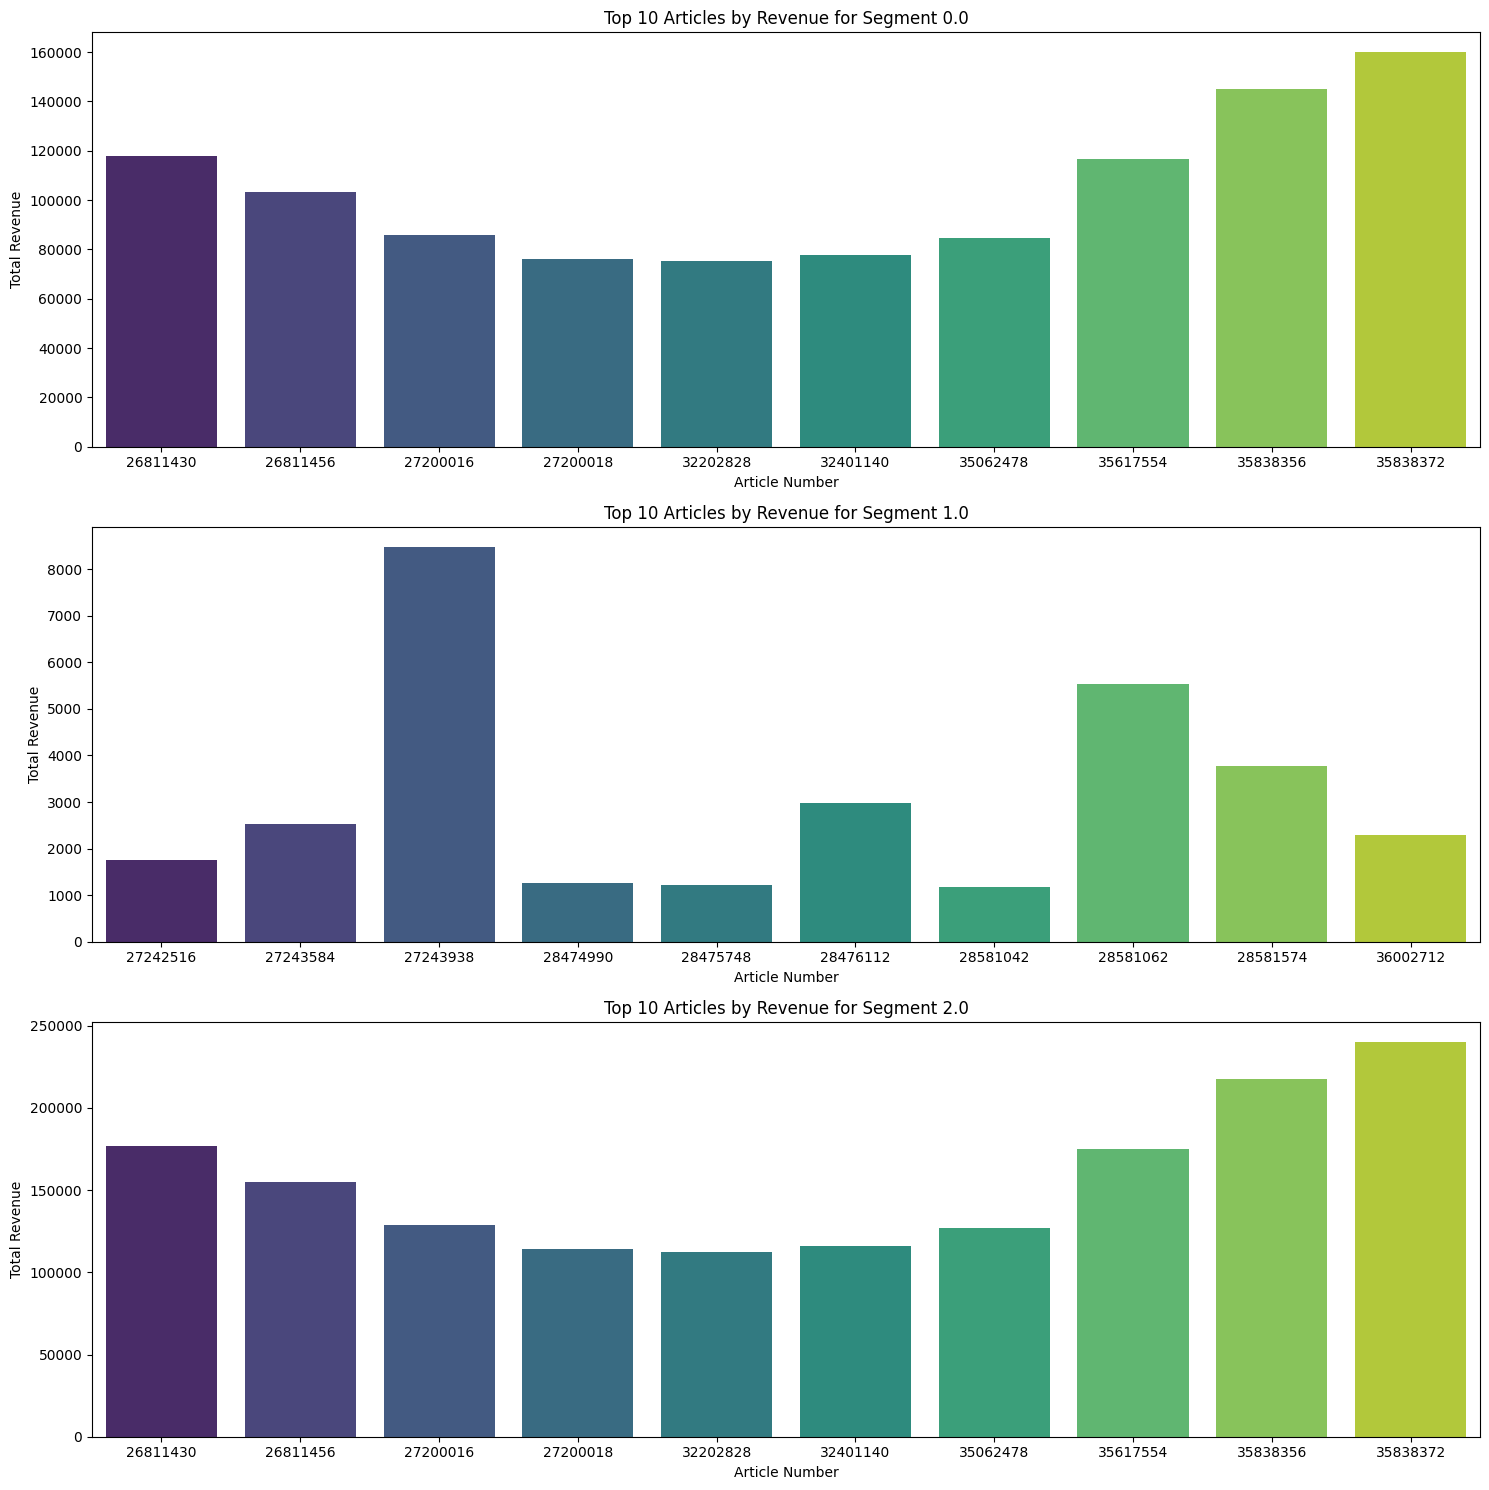

In [ ]:

# Plot top 10 articles by total revenue for each segment
segments = top_10_articles_by_segment['customer_segment'].unique()

plt.figure(figsize=(15, 5 * len(segments)))  # Adjust height based on the number of segments

for i, segment in enumerate(segments, 1):
    # Filter data for the current segment
    segment_data = top_10_articles_by_segment[top_10_articles_by_segment['customer_segment'] == segment]

    plt.subplot(len(segments), 1, i)
    sns.barplot(data=segment_data, x='articlenr', y='total_revenue', palette='viridis')
    plt.title(f"Top 10 Articles by Revenue for Segment {segment}")
    plt.xlabel("Article Number")
    plt.ylabel("Total Revenue")

plt.tight_layout()
plt.show()
